# affine-invariant MCMC package testing (Julia)

In [34]:
using Plots
using BenchmarkTools
using LaTeXStrings
using Distributions
using Statistics
using Printf
using Distributed

In [35]:
using JLD
import Random: rand
import Distributed: pmap
export Sampler, sample, reset, flat_chain, save_chain

# Random generator for the Z distribution of Goodman & Weare, where
# p(x) = 1/sqrt(x) when 1/a <= x <= a.
randZ(a::Float64) = ((a - 1.0) * rand() + 1.0)^2 / a

# The Sampler type is the interface between the user and the machinery.
mutable struct Sampler
    n_walkers::Int64
    dim::Int64
    probfn::Function
    a::Float64
    chain::Array{Float64, 3}
    ln_posterior::Array{Float64,2}
    iterations::Int64
    accepted::Int64
    args::Tuple{Vararg{Any}} # args::(Any...)
    callback::Function
end

function dummy_callback(s::Sampler, iter::Int64, saveindex::Int64, k::Int64)
end

# Constructor
function Sampler(k::Integer, dim::Integer, f::Function, a::Real, args::Tuple{Vararg{Any}}, callback::Function)
    accpt=0
    iter=0
    chain = zeros(Float64, (k, dim, 0))
    ln_p = zeros(Float64, (k, 0))
    S = Sampler(k,dim,f,a,chain,ln_p,iter,accpt,args,callback)
    return S
end

# Minimal constructors
Sampler(k::Integer, dim::Integer, f::Function, a::Real; callback::Function = dummy_callback) = Sampler(k, dim, f, a, (), callback)
Sampler(k::Integer, dim::Integer, f::Function, args::Tuple{Vararg{Any}}; callback::Function = dummy_callback) = Sampler(k, dim, f, 2.0, args, callback)
Sampler(k::Integer, dim::Integer, f::Function; callback::Function = dummy_callback) = Sampler(k, dim, f, 2.0, (), callback)

call_lnprob(S::Sampler, pos::Array{Float64}) = S.probfn(pos, S.args...)

# Return all lnprobs at given position
function get_lnprob(S::Sampler, pos::Array{Float64})
    lnprob = zeros(Float64, S.n_walkers)
    for k = 1:S.n_walkers
	lnprob[k] = call_lnprob(S, vec(pos[k,:]))
    end
    return lnprob
end

function sample_serial(S::Sampler, p0::Array{Float64,2}, N::Int64, thin::Int64, storechain::Bool)
    k = S.n_walkers
    halfk = fld(k, 2)
    
    p = copy(p0)
    lnprob = get_lnprob(S, p)
    
    i0 = size(S.chain, 3)
    
    # Add N/thin columns of zeroes to the Sampler's chain and ln_posterior
    if storechain
	S.chain = cat(S.chain, zeros(Float64, (k, S.dim, fld(N,thin))); dims = 3)
	S.ln_posterior = cat(S.ln_posterior, zeros(Float64, (k, fld(N,thin))); dims = 2)
    end
    
    first = 1 : halfk
    second = halfk+1 : k
    divisions = [(first, second), (second, first)]
    
    for i = i0+1 : i0+N
	for ensembles in divisions
	    active, passive = ensembles
	    l_pas = size(passive,1)
	    for k in active
	        X_active = vec(p[k,:])
	        choice = passive[rand(1:l_pas)]
	        X_passive = vec(p[choice,:])
	        z = randZ(S.a)
	        proposal = X_passive + z*(X_active - X_passive)
	        new_lnprob = call_lnprob(S, proposal)
	        log_ratio = (S.dim - 1) * log(z) + new_lnprob - lnprob[k]
	        if log(rand()) <= log_ratio
	            lnprob[k] = new_lnprob
	            p[k,:] .= proposal
	            S.accepted += 1
	        end
	        S.iterations += 1
                if (i - i0) % thin == 0
                    if storechain
	                S.ln_posterior[k, fld(i,thin)] = lnprob[k]
	                S.chain[k, :, fld(i,thin)] .= vec(p[k,:])
                    end # storechain
                    S.callback(S, i - i0, fld(i,thin), k)
	        end # thin
	    end # k in active
	end # ensemble
    end # main loop
    return p
end

function sample_parallel(S::Sampler, p0::Array{Float64,2}, N::Int64, thin::Int64, storechain::Bool)

    k = S.n_walkers
    halfk = fld(k, 2)
    
    p = copy(p0)
    lnprob = pmap(call_lnprob, [S for i = 1:S.n_walkers], [vec(p[i,:]) for i = 1:S.n_walkers])

    i0 = size(S.chain, 3)
    
    # Add N/thin columns of zeroes to the Sampler's chain and ln_posterior
    if storechain
	S.chain = cat(S.chain, zeros(Float64, (k, S.dim, fld(N,thin))), dims = 3)
	S.ln_posterior = cat(S.ln_posterior, zeros(Float64, (k, fld(N,thin))), dims = 2)
    end
    
    first = 1 : halfk
    second = halfk+1 : k
    divisions = [(first, second), (second, first)]
    
    # For Parallel version
    function trystep(proposalk, lnprobk, zk)
        new_lnprob = call_lnprob(S, proposalk)
        log_ratio = (S.dim - 1)*log(zk) + new_lnprob - lnprobk
        if log(rand()) <= log_ratio
            return true, new_lnprob
        else
            return false, new_lnprob
        end
    end

    for i = i0+1 : i0+N
	for ensembles in divisions
	    active, passive = ensembles
	    l_pas = size(passive,1)
            # Parallel version
            # Construct a list of proposed steps and evaluate in parallel
            zs = [randZ(S.a) for k in active]
            proposals = [ (1 - zs[ki])*vec(p[passive[rand(1:l_pas)],:]) + zs[ki]*vec(p[k,:]) for (ki,k) in enumerate(active) ]
            lnprobs = [lnprob[k] for k in active]
            results = pmap(trystep, proposals, lnprobs, zs)
            for (ki, (accept, new_lnprob)) in enumerate(results)
                k = active[ki]
                if accept
                    lnprob[k] = new_lnprob
                    p[k,:] .= proposals[ki]
                    S.accepted +=1
                end
                S.iterations += 1
                if (i - i0) % thin == 0
                    if storechain
	                S.ln_posterior[k, fld(i,thin)] = lnprob[k]
	                S.chain[k, :, fld(i,thin)] .= vec(p[k,:])
                    end # storechain
                    S.callback(S, i - i0, fld(i,thin), k)
	        end # thin
            end # collect results
	end # ensemble
    end # main loop
    return p
end

function sample(S::Sampler, p0::Array{Float64,2}, N::Int64, thin::Int64, storechain::Bool, parallel::Bool = nprocs() > 1)
    if parallel
        sample_parallel(S, p0, N, thin, storechain)
    else
        sample_serial(S, p0, N, thin, storechain)
    end
end

function sample(S::Sampler, N::Int64, thin::Int64, storechain::Bool)
    N = size(S.chain, 3)
    if N == 0
	error("No initial position for chain!")
    end
    p0 = S.chain[:,:,N]
    sample(S, p0, N, thin, storechain)
end

sample(S::Sampler, N::Int64) = sample(S, N, 1, true)
sample(S::Sampler, N::Int64, storechain::Bool) = sample(S, N, 1, storechain)


# Reset a Sampler to state after construction.
function reset(S::Sampler)
    k = S.n_walkers
    S.chain = zeros(Float64, (k, S.dim, 0))
    S.ln_posterior = zeros(Float64, (k, 0))
    S.accepted = 0
    S.iterations = 0
    return S
end

# Flatten the chain along the walker axis
function flat_chain(S::Sampler)
    walkers,dimensions,steps = size(S.chain)
    flatchain = zeros((dimensions, walkers*steps))
    for step = 1:steps
	k = (step-1)*walkers + 1
	for dim = 1:dimensions
	    flatchain[dim, k:(k+walkers-1)] .= S.chain[:,dim,step]
	end
    end
    return flatchain
end

# Squash the chains and save them in a csv file
function save_chain(S::Sampler, filename::AbstractString)
    # flatchain = flat_chain(S)
    # writecsv(filename, flatchain)
    save(filename, "chain", S.chain, "ln_posterior", S.ln_posterior)
end

save_chain (generic function with 1 method)

### Create mock data

The mock data we will create is drawn from the distribution $f$ which has PDF 
$$f(v| v_{esc},k) = \frac{k+1}{v_{esc}{}^{k+1}} (v_{esc} - v)^k \quad,\quad v\in[0,v_{esc}]$$

and CDF
$$ \text{CDF}_f(v) =  \left( 1 - \frac{v}{v_{esc}} \right)^{k+1} -1 \quad,\quad v\in[0,v_{esc}]$$

which has inverse 
$$  \text{CDF}_f{}^{-1}(y) = v_{esc}\left[ 1 - (1-y)^{\frac{1}{k+1}}  \right] \quad,\quad y\in[0,1] $$

We need the inverse CDF to generate samples from this distribution. Note also that the log likelihood is given by
$$ Log\left(\text{Likelihood} (D|v_{esc},k)  \right) = \sum_d Log(f(d|vesc,k)  ) $$

for a dataset D consisting of datapoints $d$, where each term is of the form
$$  Log(f(d|vesc,k)  ) =  Log(k+1) - (k+1)Log(v_{esc}) + k~Log(v_{esc} - v) $$

In [9]:
function powerlaw_PDF(v,x)
    vesc,k = x
    return ( (k+1)*(vesc)^(-k-1) ) * (vesc - v)^k
end

function powerlaw_inverse_CDF(y,x)
    vesc,k = x
    return vesc*( 1.0 - (1.0-y)^( 1.0/(k+1.0) ) )
end

powerlaw_inverse_CDF (generic function with 1 method)

### Define helper functions

In [10]:
function generate_samples(N,inverse_CDF::Function,x)
    # To sample from a distribution we perform inverse transform sampling, for which the inverse CDF is required
    uniform_random_numbers = rand(Float64,N)
    
    return map( num -> inverse_CDF(num,x) , uniform_random_numbers )
end

generate_samples (generic function with 1 method)

### Sample from distribution to obtain data which we will fit via MCMC

We generate data with a specific escape velocity and $k$ to use in our parameter fit later

In [11]:
target_vesc = 550.0
target_k = 3.0
target_x = [target_vesc,target_k]
num_samples = 1000

target_data = generate_samples(num_samples,powerlaw_inverse_CDF,target_x);

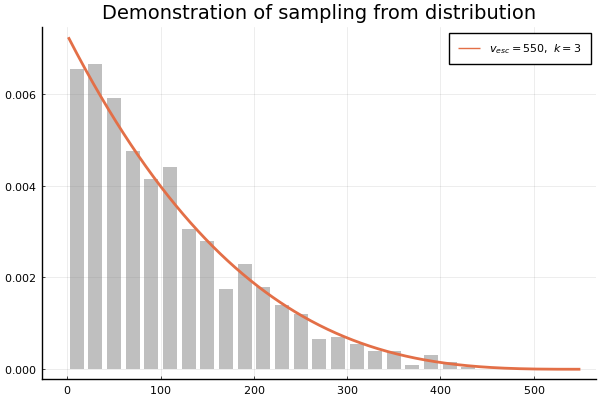

In [12]:
pyplot()

histogram(target_data, normed = true,
                    bins = 25,
                    title = "Demonstration of sampling from distribution",
                    alpha = 0.5,
                    bar_width = 15,
                    linewidth = 0,
                    color = "gray" ,
                    label = ""
                    )

v_test = collect(1:1:550)
plot!(v_test, map(v -> powerlaw_PDF(v,[550.0,3.0]) , v_test) ,
                    linewidth = 2,
                    #color = "red",
                    label = L"v_{esc}=550,~k=3"
                    )

# Define MCMC functions and parameters

In [18]:
function log_prior(x)
    vesc,k = x
    if 100.0 < vesc < 800.0 && 0.2 < k < 10.0 
        return 0.0
    end

    return -Inf
end

function log_likelihood(x,data)
    vesc,k = x
    sum = 0.0
    for v in data
        #println("v = ",v,", vesc = ",vesc)
        if v < vesc
            sum += log(k+1.0) - (k+1.0)*log(vesc) + k*log(vesc - v)
        else
            return -Inf 
        end
    end
    return sum
end

function log_probability(x,data)
    return log_likelihood(x,data) + log_prior(x)
end

#function log_probability_vectorized(x_vector,data)
#    return_vector = zeros(length(x_vector))

log_probability (generic function with 2 methods)

# Use MCJulia to perform sampling

### Parameters and initial conditions for walkers

In [36]:
# Parameters
ndims = 2
nwalkers = 10
nsamples_perwalker = 1000
burnin = 10

# ICs
guess_vesc = 600
guess_k = 4

initial_guess_dist = MvNormal([0.0,0.0],[90 0.0 ; 0.0 0.9])

initial_guess_onewalker = [guess_vesc,guess_k]
initial_guess = reshape( reduce(hcat, [initial_guess_onewalker + vec(rand(initial_guess_dist , 1))  for _ in 1:nwalkers]) ,
                         (nwalkers,ndims))

quantile_list = [0.16, 0.5, 0.84];


In [37]:
seed!(0)
S = Sampler(nwalkers, ndims, log_probability, (target_data,))

Sampler(10, 2, log_probability, 2.0, Array{Float64, 3}(undef, 10, 2, 0), Matrix{Float64}(undef, 10, 0), 0, 0, ([98.20791896566853, 58.21756552901358, 103.32733479039364, 75.72616995789096, 0.5894436214505749, 192.67350425116078, 106.95201036570346, 97.03057825422704, 271.12672786709277, 33.40920664502916  …  0.5799806585866485, 115.57642541108349, 220.81893041933822, 250.6033679083438, 43.961476409047606, 259.91085729725296, 248.05436816446195, 9.5563996275218, 152.08072741832953, 22.737482317834594],), dummy_callback)

In [38]:
# Do a 20-step burn-in without saving the results.  Since we have
# 100 walkers, we are throwing away 2000 samples. The return value
# p is the position of the walkers at the last step.
p = sample(S, initial_guess, burnin,1,false)

10×2 Matrix{Float64}:
 608.946    592.293
   4.12705    2.04473
 614.468    602.97
   4.11754    3.54517
 588.561    591.041
   4.29582    5.7307
 597.774    589.96
   2.96845    4.27717
 604.386    611.829
   3.92354    3.59275

In [40]:
sample(S, p, 100, 1, true)
println("acceptance ratio: $(S.accepted / S.iterations)")

acceptance ratio: 0.0


# Run MH algorithm

In [ ]:
num_steps = 40000
burnin = 200
initial_guess = [600.0,4.0]

quantile_list = [0.16, 0.5, 0.84]

accepted, rejected = metropolis_hastings(target_data, 
                                        num_steps,
                                        initial_guess,
                                        log_likelihood, 
                                        log_prior, 
                                        step_model, 
                                        step_decision
                                        )

### Strip the zeros

In [ ]:
accepted_col_indices = zeros(Int64,0)
rejected_col_indices = zeros(Int64,0)

for (i,col) in enumerate(eachcol(accepted))
    if col != [0,0]
        append!(accepted_col_indices,i)
    end
end

for (i,col) in enumerate(eachcol(rejected))
    if col != [0,0]
        append!(rejected_col_indices,i)
    end
end

accepted_stripped = accepted[:,accepted_col_indices]
rejected_stripped = rejected[:,rejected_col_indices];

### Process the data

In [ ]:
# final data to be used
vesc_posterior = accepted_stripped[1,burnin:end]
k_posterior = accepted_stripped[2,burnin:end]

# Examine acceptance fraction
println(length(accepted_stripped) / length(rejected_stripped)) # a decent proxy for real value

# Establish estimates of parameters via median and expected error on these estimates
vesc_quantiles = quantile(vesc_posterior, quantile_list)
k_quantiles = quantile(k_posterior, quantile_list)


vesc_median = vesc_quantiles[2]
vesc_lower_1sigma = vesc_median - vesc_quantiles[1]
vesc_upper_1sigma = vesc_quantiles[3] - vesc_median

k_median = k_quantiles[2]
k_lower_1sigma = k_median - k_quantiles[1]
k_upper_1sigma = k_quantiles[3] - k_median;

In [ ]:
plot(vesc_posterior, normed = true,
                    bins = 25,
                    title = "MCMC result, \$v_{esc} =\$ $(@sprintf("%.2f", vesc_median)) \$ ^{+$(@sprintf("%.2f", vesc_upper_1sigma))}_{+$(@sprintf("%.2f", vesc_lower_1sigma))}\$ ",
                    #alpha = 0.5,
                    #bar_width = 15,
                    #linewidth = 0,
                    #color = "gray" ,
                    lc="black",
                    label = "",
                    seriestype=:stephist,
                    size=(500,400),
                    )
vline!([target_vesc], lw = 2, label = L"True $v_{esc}$")

vline!(vesc_quantiles , ls=:dash, color="black",lw=1,label="" )

In [ ]:
plot(k_posterior, normed = true,
                    bins = 25,
                    title = "MCMC result, \$k =\$ $(@sprintf("%.2f", k_median)) \$ ^{+$(@sprintf("%.2f", k_upper_1sigma))}_{+$(@sprintf("%.2f", k_lower_1sigma))}\$ ",
                    #alpha = 0.5,
                    #bar_width = 15,
                    #linewidth = 0,
                    #color = "gray" ,
                    lc="black",
                    label = "",
                    seriestype=:stephist,
                    size=(500,400),
                    )
vline!([target_k], lw = 2, label = L"True $k$")

vline!( k_quantiles, ls=:dash, color="black",lw=1, label="")